In [1]:
import numpy as np 
import sys
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.environment.env_example import EnvironmentExample
from src.agents.exp3 import Exp3
import seaborn as sns
colors = sns.color_palette('colorblind')

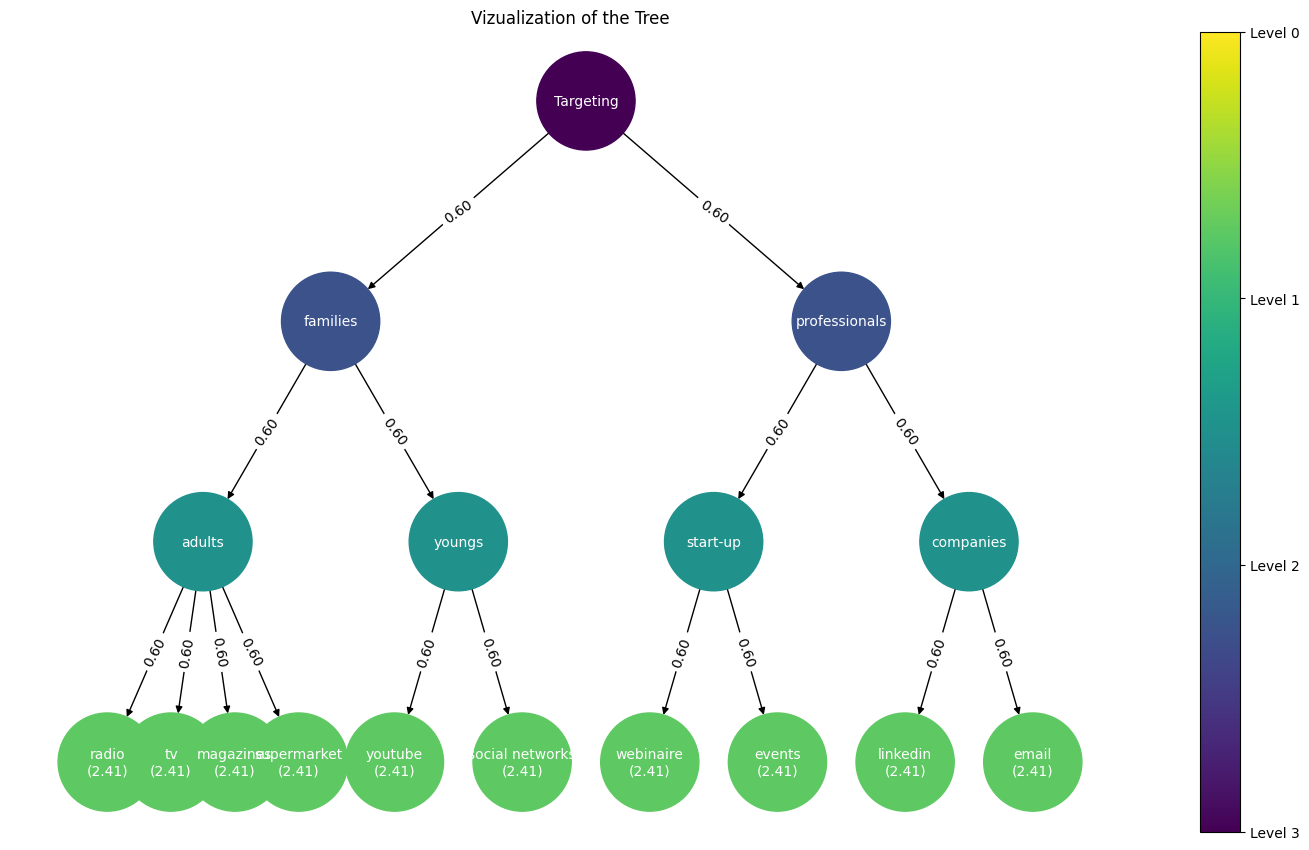

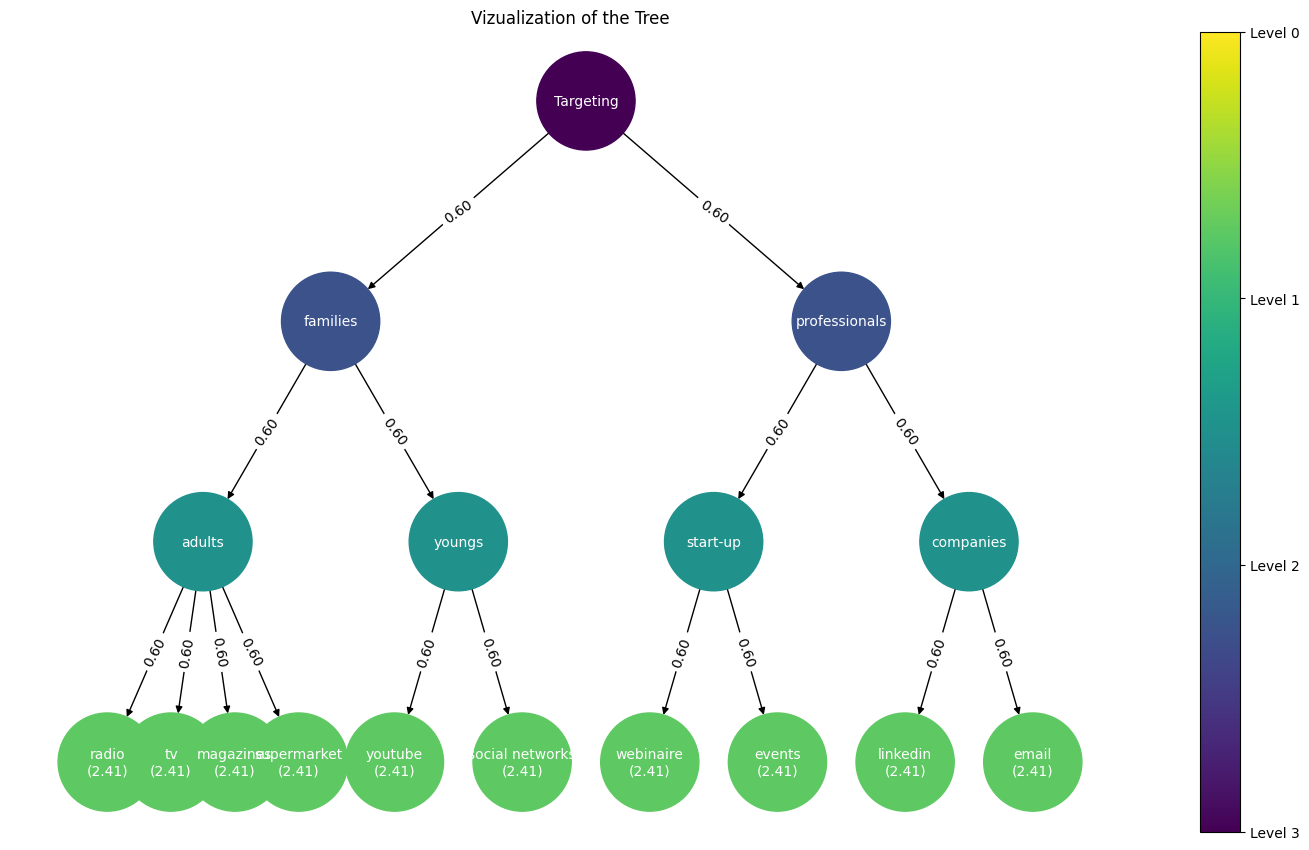

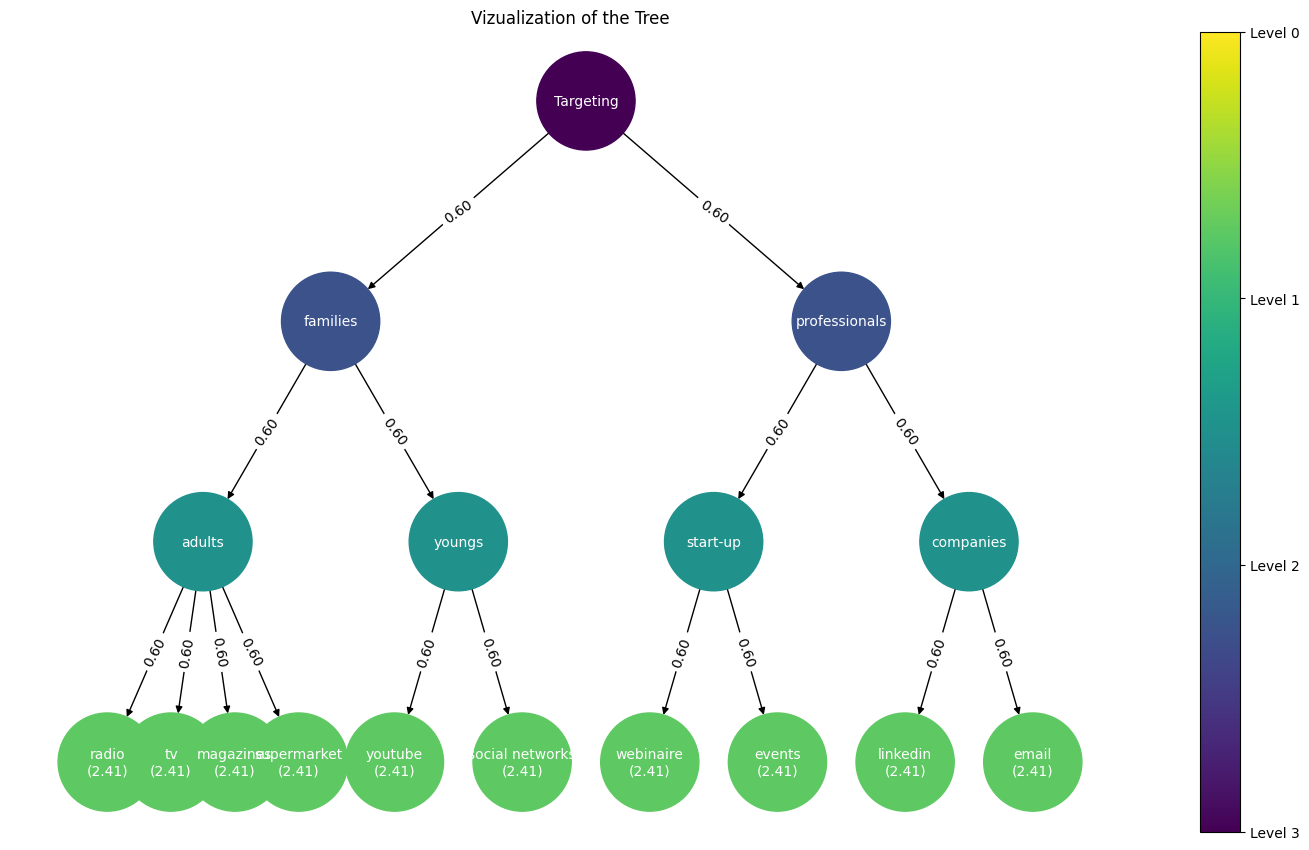

In [2]:
env = EnvironmentExample()
for t in range(3):
    env.step()
    env.tree.visualize_tree()


In [3]:
def experiment(environment, agents, Nmc, T):
    all_data = {}
    best_path, best_reward = environment.get_best_strategy_reward()
    for agent in agents:
        agent_id, regrets = play(environment, agent, Nmc, T)
        all_data[agent_id] = regrets
    return all_data

def play(environment, agent, Nmc, T):
    data = np.zeros((Nmc, T))
    env = environment
    action_set = environment.get_action_set()

    for episode in tqdm(range(Nmc)):
        env.reset()
        agent.reset()
        best_path, best_reward = environment.get_best_strategy_reward()
        for t in range(T):
            if agent.nested():
                path = agent.get_path()
                received_reward, path_reward = env.get_reward_by_path(path)
                agent.receive_reward(received_reward, path_reward, path)
            else:
                action_index = agent.get_action(t)
                leaf = action_set[action_index]
                received_reward = env.get_reward(action_index)
                #print(received_reward, best_reward)
                agent.receive_reward(received_reward, action_index)
            
            env.step()
            data[episode, t] = best_reward - received_reward
            best_path, best_reward = environment.get_best_strategy_reward()

    return agent.name(), data

def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None):
    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)
        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)
    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)
    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))
    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_6043/3294178321.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


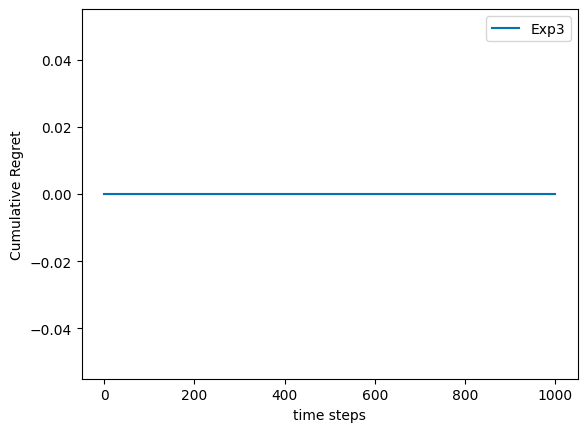

In [4]:
from src.agents.exp3 import Exp3

T = 1000  # Finite Horizon
N = 1  # Monte Carlo simulations
q = 10  #choice of percentile display


# Framework for the experiments
env = EnvironmentExample()
action_set = env.get_action_set()

# Initialization of the agents
exp3 = Exp3(action_set=action_set)


# Run experiments
all_data = experiment(env, [exp3], Nmc=N, T=T)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5)